In [1]:
# sentiment Analisis 

In [2]:
#import libraries
import tweepy

from textblob import TextBlob as tb
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

!pip install PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

plt.style.use('fivethirtyeight')
import json

!pip install googletrans==4.0.0-rc1
from googletrans import Translator

In [3]:
# Load the Data
from google.colab import files
uploaded = files.upload()

In [4]:
#Get the data
log = pd.read_csv('login.csv')

In [5]:
#Twiter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [6]:
# Create the Authentication objaect
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Set the access token and access toke secret
authenticate.set_access_token(accessToken, accessTokenSecret)

#Create the Api Object while passing in the auth info
api = tweepy.API(authenticate, wait_on_rate_limit=True)

In [ ]:
search_words = "vaksin OR sinovac -filter:retweets"
date_since = "2021-01-17"

tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="id",
              result_type="recent",
              tweet_mode="extended").items(10000)

# Print the last 5 tweets from query
json_data = [r._json for r in tweets]

df = pd.json_normalize(json_data)
df.head()

In [24]:
# Menghilangkan Duplikat
df = df.drop_duplicates(subset='full_text', keep='first').reset_index()
df.shape

(993, 173)

In [9]:
#import kamus alay dan Stopword bahasa indonesia
from google.colab import files
uploaded = files.upload()

In [25]:
#Slang Word Replacement

slang_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
slang_dict = slang_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})
stopwords_new = pd.DataFrame(['sih','nya', 'iya', 'nih', 'biar', 'tau', 'kayak', 'banget'], columns=['stopword'])
id_stopword_dict = pd.concat([id_stopword_dict,stopwords_new]).reset_index()
id_stopword_dict = pd.DataFrame(id_stopword_dict['stopword'])

In [26]:
slang_dict.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [27]:
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [28]:
#Stemmer, link, char, dan beberapa kata ganti

factory = StemmerFactory()
stemmer = factory.create_stemmer()


def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) # Remove every pic 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    
    text = re.sub('gue','saya',text) # Sub gue saya
    text = re.sub('\n',' ',text) # Remove every '\n'
    
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    
    to_delete = ['hypertext', 'transfer', 'protocol', 'over', 'secure', 'socket', 'layer', 'dtype', 'tweet', 'name', 'object'
                 ,'twitter','com', 'pic', ' ya ']
    
    for word in to_delete:
        text = re.sub(word,'', text)
        text = re.sub(word.upper(),' ',text)
    
    retweet_user = [' rt ', ' user ']
    
    for word in retweet_user:
        text = re.sub(word,' ',text) # Remove every retweet symbol & username
        text = re.sub(word.upper(),' ',text)
        
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

slang_dict_map = dict(zip(slang_dict['original'], slang_dict['replacement']))

def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

In [29]:
def preprocess(text):
    text = lowercase(text)
    text = remove_unnecessary_char(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_slang(text)
    text = stemming(text) 
    text = remove_stopword(text)
    return text

In [30]:
df['full_text'] = df['full_text'].apply(preprocess).apply(preprocess)

In [31]:
df = df.drop_duplicates(subset='full_text', keep='first').reset_index()
df.shape

(955, 174)

In [32]:
df.to_csv('vaksin-pemerintah-preprocessed.csv', index=False)

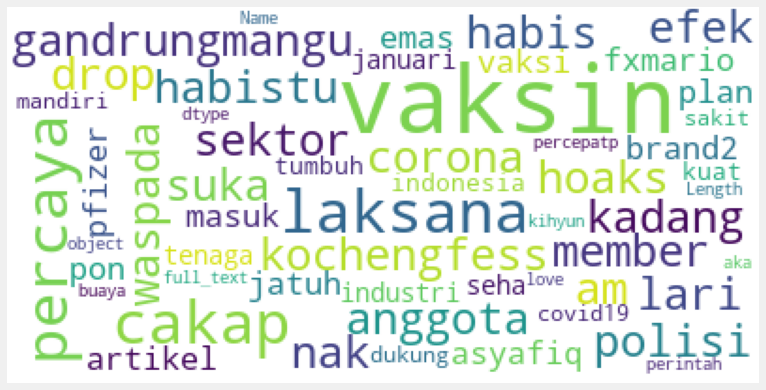

In [34]:
mpl.rcParams['figure.figsize']=(12.0,12.0) 
mpl.rcParams['font.size']=12              
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=id_stopword_dict,
                          max_words=400,
                          max_font_size=50, 
                          random_state=69
                         ).generate(str(df['full_text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [35]:
translator = Translator()
translator.translate('nice', dest='id').text

'bagus'

In [36]:
  def en_to_id(sentence):
    if tb(sentence).detect_language() == 'en':
        return tb(sentence)
    
    translator = Translator()
    
    output = translator.translate(sentence, dest='en')
    return tb(output.text)
    
def get_sentiment(sentence):
    sentence = en_to_id(sentence)
    return sentence.sentiment

def round_polarity(value):
    if value >= 0.3:
        return 1
    elif value == 0:
        return 0
    return -1

def round_subjectivity(value):
    if value >= 0:
        return 1
    elif value == 0:
        return 0
    return -1

In [37]:
tweets = df['full_text']
polarity = []
subjectivity = []

for tweet in tweets:
    sentiment = get_sentiment(tweet)
    
    polarity.append(round_polarity(sentiment[0]))
    subjectivity.append(round_subjectivity(sentiment[1]))

HTTPError: ignored